# Demo
1. Show two json files as the inputs
2. Post to terrarium funman api, show response id
3. Get result from id, and plot

# Todo
1. How to interact with terrarium
2. *DONE* Setup API for two json files
3. *DONE* Setup async anytime results
4. *DONE* Truncate/halt request endpoint
5. *DONE* Allow multiple requests in a queue, needs server thread

# Demo Setup

In [1]:
# Common imports
import asyncio
import nest_asyncio
import os
import json
from pathlib import Path

from IPython.display import JSON

# Setup URLs
API_BASE_PATH = os.path.join(os.getcwd(), "..")
# Currently assumes a localhost server us running (see funman_server.ipynb)
API_SERVER_HOST = "127.0.0.1"
API_SERVER_PORT = 8190
SERVER_URL = f"http://{API_SERVER_HOST}:{API_SERVER_PORT}"
OPENAPI_URL = f"{SERVER_URL}/openapi.json"
CLIENT_NAME = "funman-api-client"

# Setup Paths
RESOURCES = Path("../resources").resolve()


# Install API client to the working directory
# and add the install to the sys path
import funman.api.client as client
client.make_client(
    API_BASE_PATH, openapi_url=OPENAPI_URL, client_name=CLIENT_NAME
)
nest_asyncio.apply()


# Setup API client request
from funman_api_client import Client
from funman_api_client.api.default import (
    post_queries_queries_post,
    get_queries_queries_query_id_get,
)
from funman_api_client.models.body_post_queries_queries_post import BodyPostQueriesQueriesPost
from funman_api_client.models import (
    BilayerModel,
    FUNMANConfig,
    LabeledParameter,
    QueryLE,
    FunmanWorkRequest,
    FunmanWorkUnit,
    FunmanResults,
    QueryTrue,
    GeneratedPetriNetModel
    
)

# Create a funman client
funman_client = Client(SERVER_URL, timeout=None)

# Example 1: AMR Petrinet
---
## Example 1: Step 1: Load Model and Request

In [15]:
EXAMPLE_DIR = RESOURCES / "amr" / "petrinet" / "amr-examples"
MODEL_PATH = EXAMPLE_DIR / "sir.json"
REQUEST_PATH = EXAMPLE_DIR / "sir_request1.json"

# Read in the model file
model = json.loads(MODEL_PATH.read_bytes())
# pretty print
# print(json.dumps(model, indent=2))

# Read in the funman request file
request = json.loads(REQUEST_PATH.read_bytes())
# pretty print
print(json.dumps(request, indent=2))

{
  "query": {
    "queries": [
      {
        "variable": "S",
        "lb": 0.0
      },
      {
        "variable": "S",
        "ub": 1001.0
      },
      {
        "variable": "I",
        "lb": 0.0
      },
      {
        "variable": "I",
        "ub": 1001.0
      },
      {
        "variable": "I",
        "ub": 200.0
      },
      {
        "variable": "R",
        "lb": 0.0
      },
      {
        "variable": "R",
        "ub": 1001.0
      }
    ]
  },
  "parameters": [
    {
      "name": "beta",
      "lb": 0.0002603,
      "ub": 0.0002803,
      "label": "all"
    },
    {
      "name": "gamma",
      "lb": 0.1,
      "ub": 0.18,
      "label": "any"
    },
    {
      "name": "S0",
      "lb": 1000,
      "ub": 1000,
      "label": "any"
    },
    {
      "name": "I0",
      "lb": 1,
      "ub": 1,
      "label": "any"
    },
    {
      "name": "R0",
      "lb": 0,
      "ub": 0,
      "label": "any"
    }
  ],
  "structure_parameters": [
    {
      "name": "num_

## Example 1: Step 2: Submit job

In [7]:
# Make a POST request to the API endpoint
response = asyncio.run(
    post_queries_queries_post.asyncio_detailed(
        client=funman_client,
        json_body=BodyPostQueriesQueriesPost.from_dict({
            "model": model,
            "request": request
        }),
    )
)

# The response returns a work unit
work_unit = FunmanWorkUnit.from_dict(
    src_dict=json.loads(response.content.decode())
)
# Where the id can be used to pull ongoing results
work_unit.id

'a83d0130-2121-497c-a043-6c5fc1e50be7'

## Example 1: Step 3: Request results

In [8]:
# Make a GET request to the API endpoint
response = asyncio.run(get_queries_queries_query_id_get.asyncio_detailed(
    work_unit.id,
    client=funman_client
))
# The response returns the latest funman results for the query
results = FunmanResults.from_dict(
    src_dict=json.loads(response.content.decode())
)
# pretty print the parameter_space
print(json.dumps(results.parameter_space.to_dict(), indent=2))

{
  "num_dimensions": 3,
  "true_boxes": [
    {
      "label": "true",
      "bounds": {
        "beta": {
          "lb": 0.0002603,
          "ub": 0.0002803
        },
        "gamma": {
          "lb": 0.1,
          "ub": 0.18
        },
        "S0": {
          "lb": 1000.0,
          "ub": 1000.0
        },
        "I0": {
          "lb": 1.0,
          "ub": 1.0
        },
        "R0": {
          "lb": 0.0,
          "ub": 0.0
        },
        "num_steps": {
          "lb": 1.0,
          "ub": 1.0
        },
        "step_size": {
          "lb": 1.0,
          "ub": 1.0
        }
      }
    },
    {
      "label": "true",
      "bounds": {
        "beta": {
          "lb": 0.0002603,
          "ub": 0.0002803
        },
        "gamma": {
          "lb": 0.1,
          "ub": 0.18
        },
        "S0": {
          "lb": 1000.0,
          "ub": 1000.0
        },
        "I0": {
          "lb": 1.0,
          "ub": 1.0
        },
        "R0": {
          "lb": 0.0,
  

## Example 1: Step 4: Plot Results

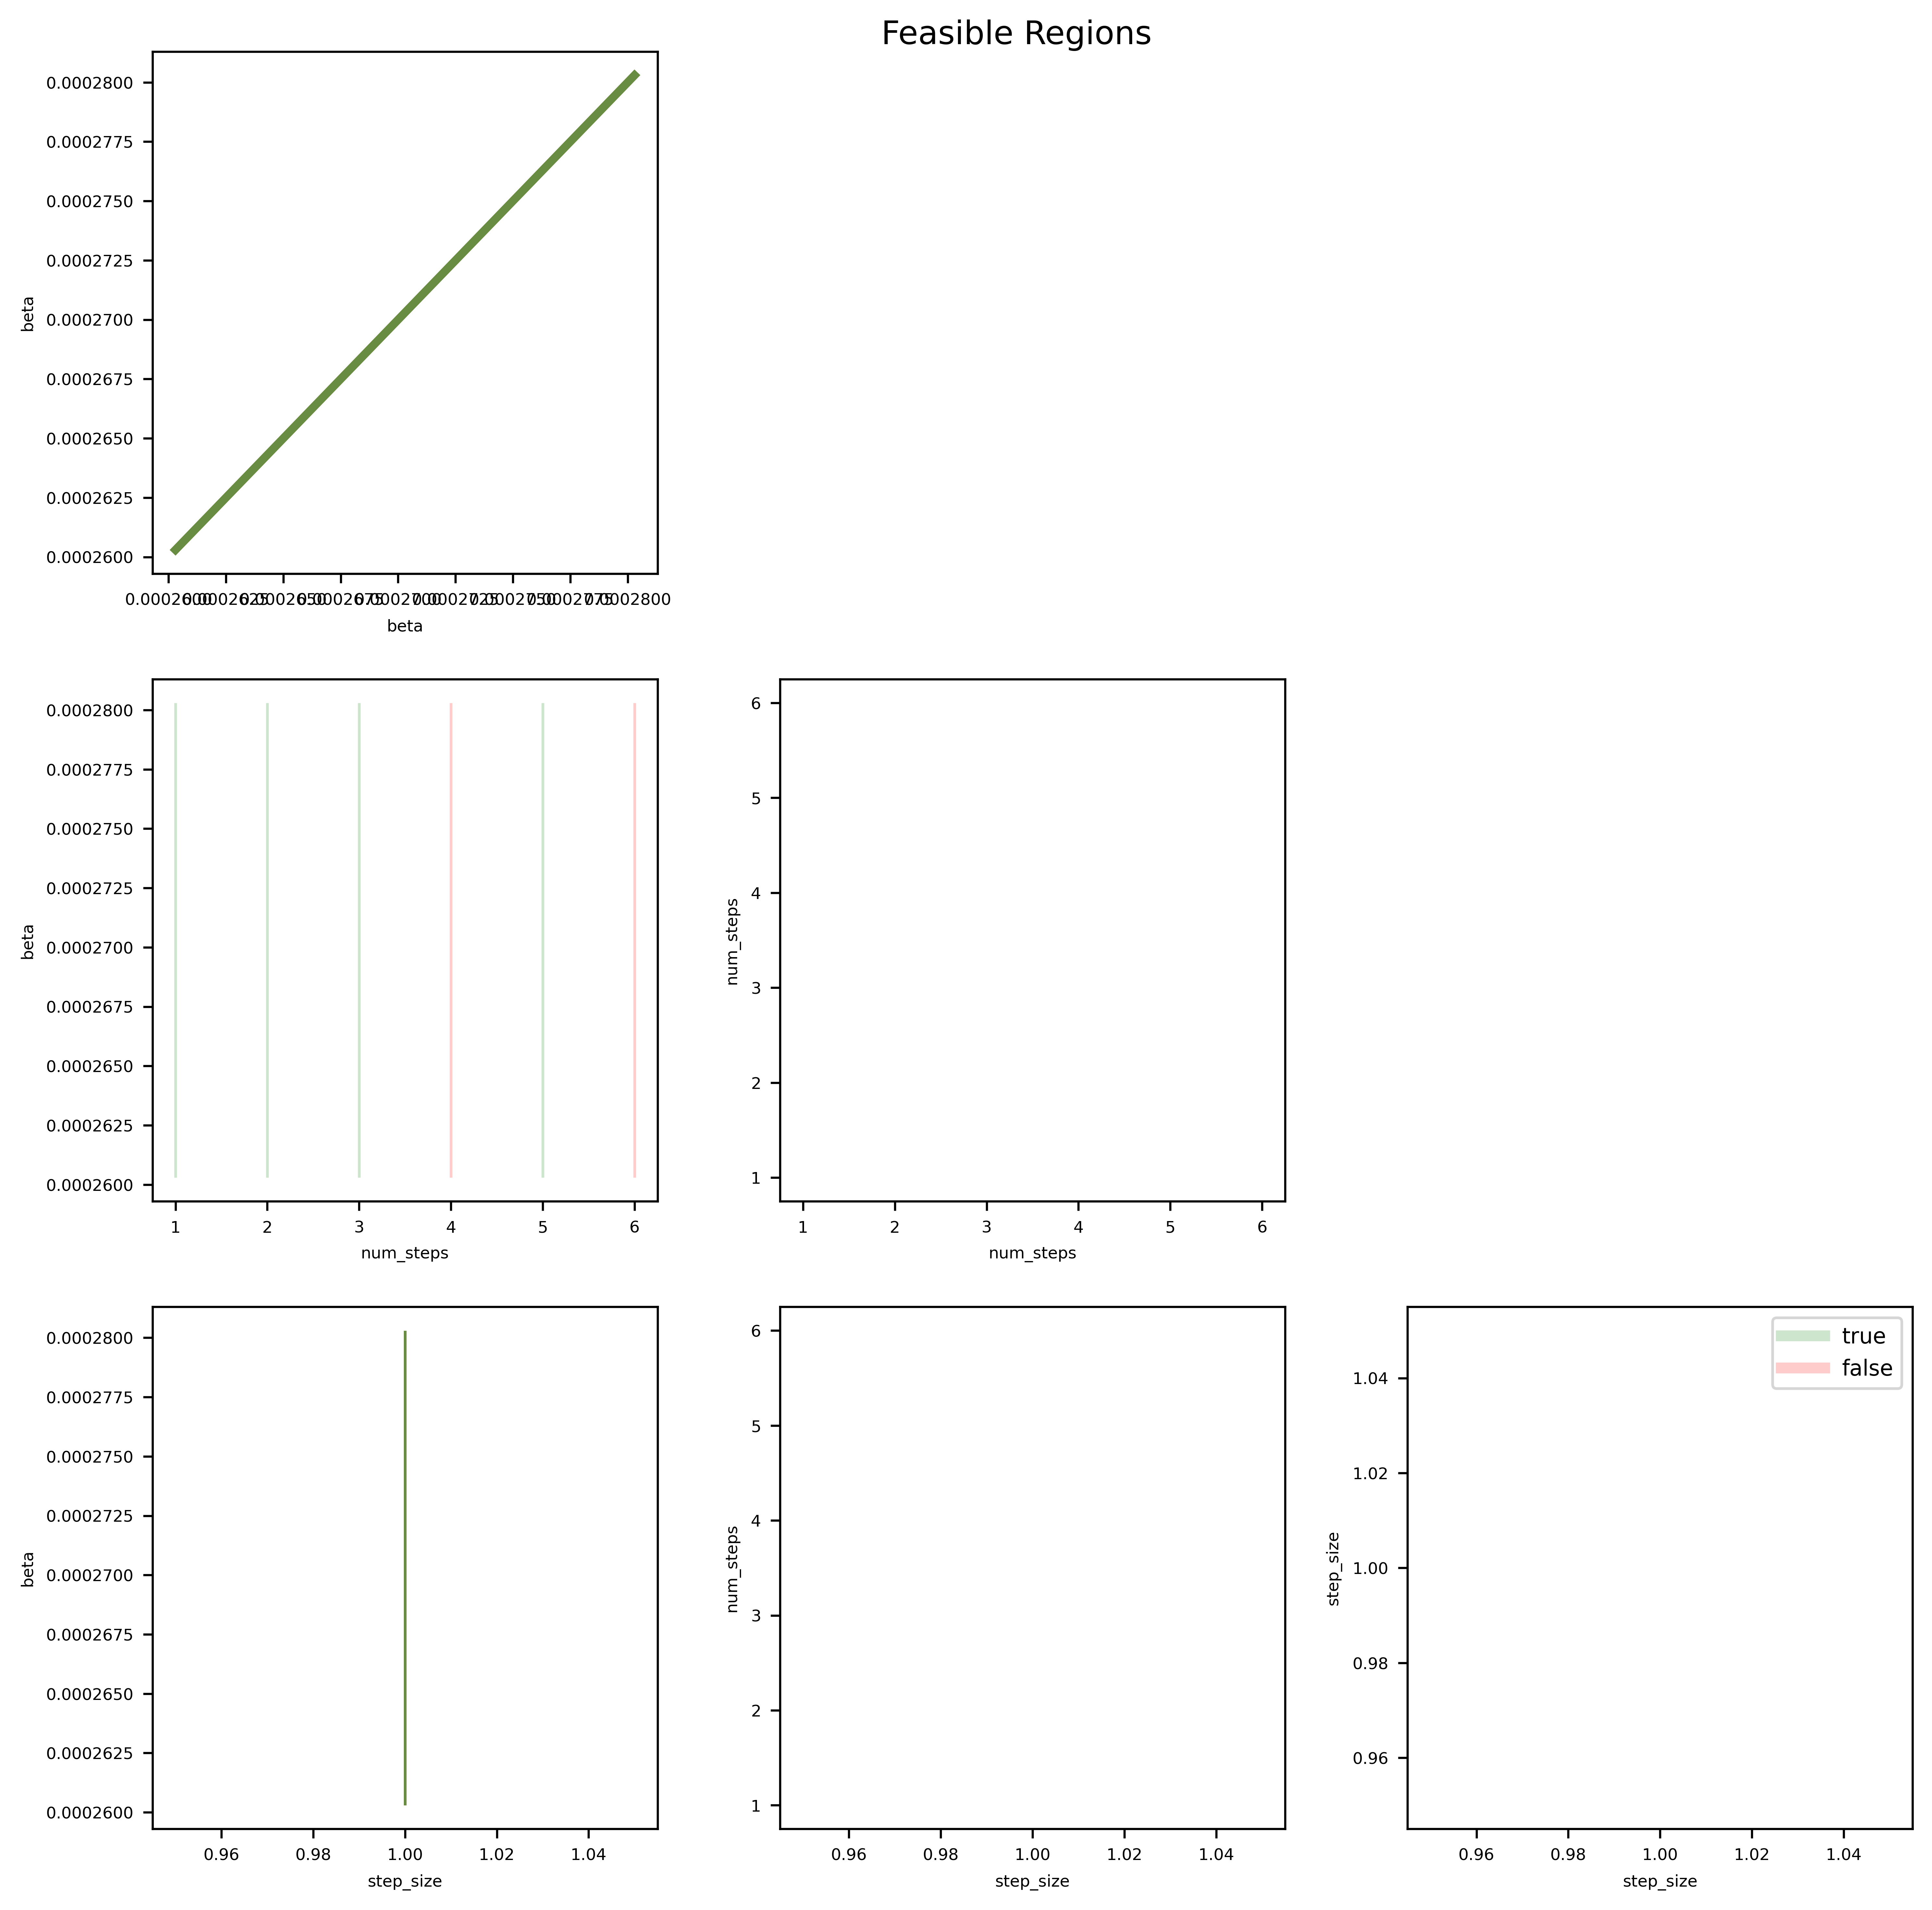

In [25]:
# Plot the ParameterSpace
from funman_demo.parameter_space_plotter import ParameterSpacePlotter
ParameterSpacePlotter(results.parameter_space).plot(show=True)

# Example 2: AMR Regnet
---
## Example 2: Step 1: Load Model and Request

In [16]:
EXAMPLE_DIR = RESOURCES / "amr" / "regnet" / "amr-examples"
MODEL_PATH = EXAMPLE_DIR / "lotka_volterra.json"
REQUEST_PATH = EXAMPLE_DIR / "sir_request1.json"

# Read in the model file
model = json.loads(MODEL_PATH.read_bytes())
# pretty print
# print(json.dumps(model, indent=2))

# Read in the funman request file
request = json.loads(REQUEST_PATH.read_bytes())
# pretty print
print(json.dumps(request, indent=2))

{
  "query": {
    "queries": [
      {
        "variable": "R",
        "lb": 0.0
      },
      {
        "variable": "R",
        "ub": 100.0
      },
      {
        "variable": "W",
        "lb": 0.0
      },
      {
        "variable": "W",
        "ub": 1000.0
      }
    ]
  },
  "parameters": [
    {
      "name": "alpha",
      "lb": 0.667,
      "ub": 0.667,
      "label": "any"
    },
    {
      "name": "beta",
      "lb": 1.333,
      "ub": 1.333,
      "label": "all"
    },
    {
      "name": "gamma",
      "lb": 1,
      "ub": 1,
      "label": "any"
    },
    {
      "name": "delta",
      "lb": 1,
      "ub": 1,
      "label": "all"
    }
  ],
  "structure_parameters": [
    {
      "name": "num_steps",
      "lb": 1,
      "ub": 7,
      "label": "all"
    },
    {
      "name": "step_size",
      "lb": 1,
      "ub": 1,
      "label": "all"
    }
  ],
  "config": {}
}


## Example 2: Step 2: Submit job

In [17]:
# Make a POST request to the API endpoint
response = asyncio.run(
    post_queries_queries_post.asyncio_detailed(
        client=funman_client,
        json_body=BodyPostQueriesQueriesPost.from_dict({
            "model": model,
            "request": request
        }),
    )
)

# The response returns a work unit
work_unit = FunmanWorkUnit.from_dict(
    src_dict=json.loads(response.content.decode())
)
# Where the id can be used to pull ongoing results
work_unit.id

'0a3be7cf-ae84-48e9-9d7f-e5f5ec0c624f'

## Example 2: Step 3: Request results

In [22]:
# Make a GET request to the API endpoint
response = asyncio.run(get_queries_queries_query_id_get.asyncio_detailed(
    work_unit.id,
    client=funman_client
))
# The response returns the latest funman results for the query
results = FunmanResults.from_dict(
    src_dict=json.loads(response.content.decode())
)
# pretty print the parameter_space
print(json.dumps(results.parameter_space.to_dict(), indent=2))

{
  "true_boxes": [],
  "false_boxes": [],
  "true_points": [],
  "false_points": []
}


## Example 2: Step 4: Plot Results

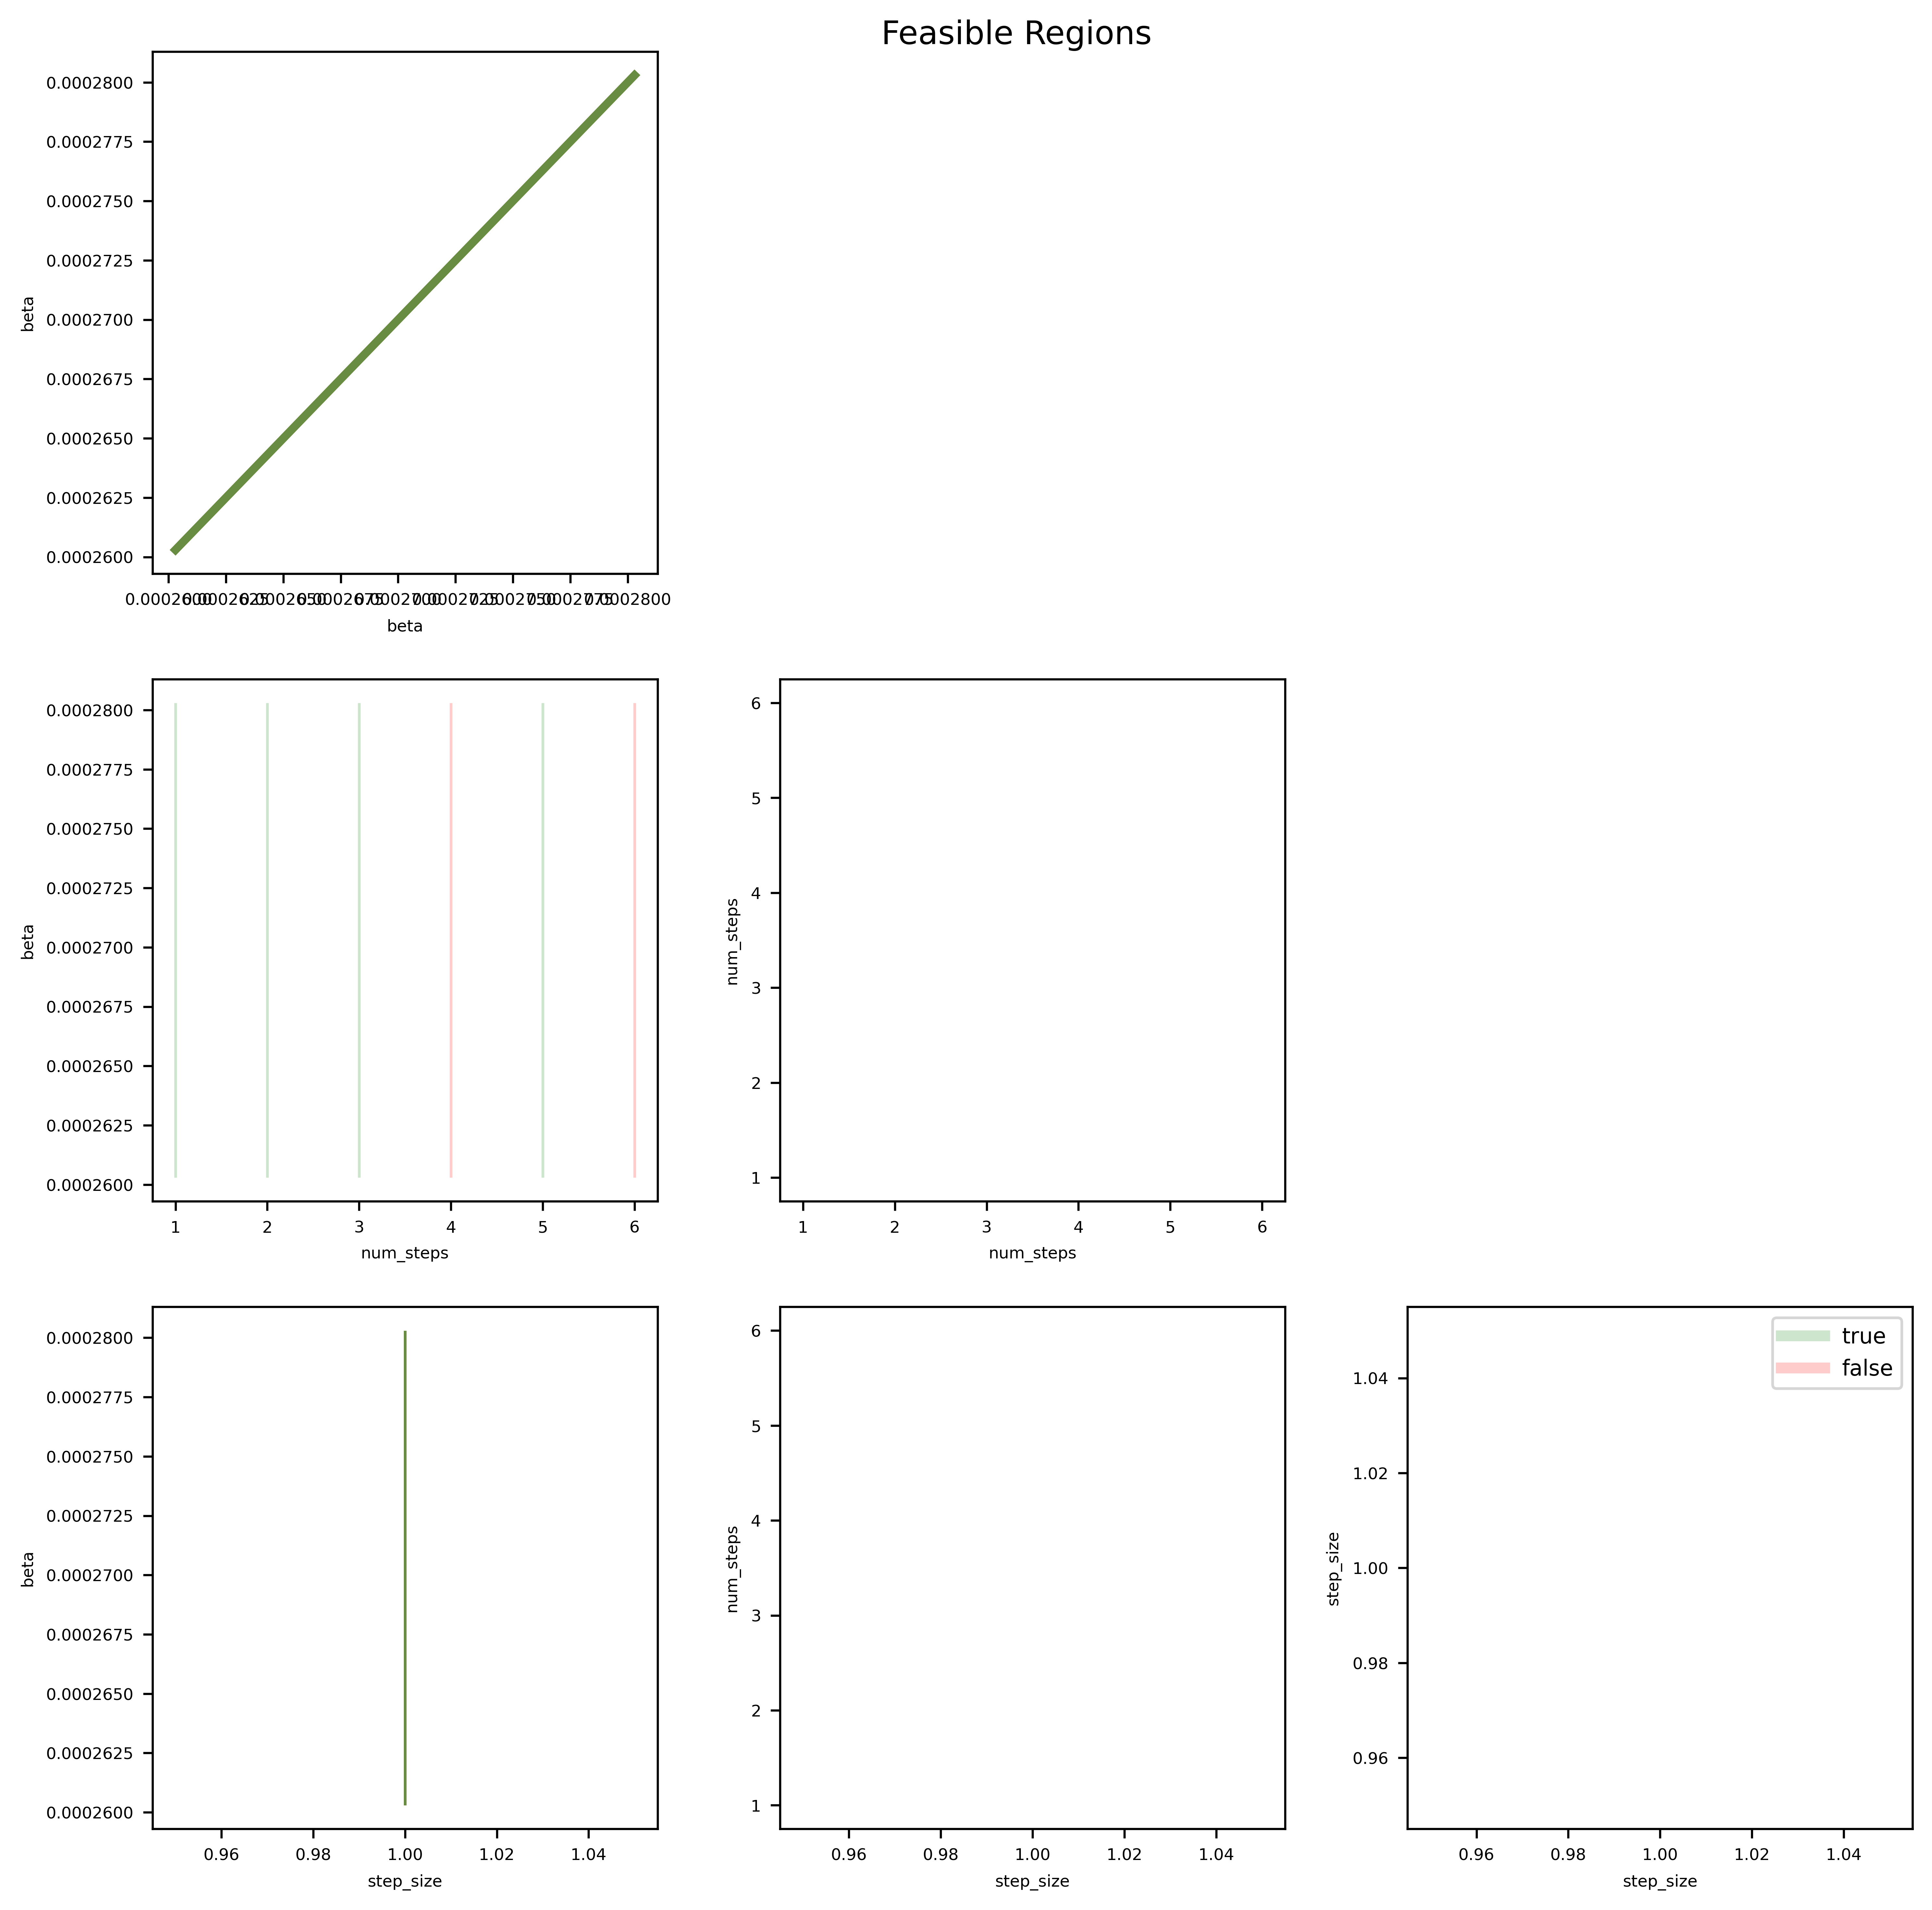

In [ ]:
# Plot the ParameterSpace
from funman_demo.parameter_space_plotter import ParameterSpacePlotter
ParameterSpacePlotter(results.parameter_space).plot(show=True)

# Optional: Halt Processing Job

In [12]:
# Halt the current run
from funman_api_client.api.default import (
    halt_queries_query_id_halt_get
)

response = asyncio.run(
    halt_queries_query_id_halt_get.asyncio_detailed(
        client=funman_client,
        query_id=work_unit.id
    )
)

# The response returns a status
response

Response(status_code=<HTTPStatus.OK: 200>, content=b'"Success"', headers=Headers({'date': 'Tue, 27 Jun 2023 14:17:22 GMT', 'server': 'uvicorn', 'content-length': '9', 'content-type': 'application/json'}), parsed='Success')